In [1]:
#Importing packages
import pandas as pd                 
import numpy as np                   
from matplotlib import pyplot as plt
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import time
import pickle

df = pd.read_csv('Traffic_Volume.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   date_time       48204 non-null  object 
 7   traffic_volume  48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 2.9+ MB


In [2]:
#Used Gemini here to extract month, weekday, and hour
df['month'] = pd.to_datetime(df['date_time']).dt.strftime('%B')
df['weekday'] = pd.to_datetime(df['date_time']).dt.strftime('%A') 
df['hour'] = pd.to_datetime(df['date_time']).dt.hour
df['hour'] = df['hour'].astype(str)

C:\Users\Tillman\AppData\Local\Temp\ipykernel_126916\3831711835.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['date_time']).dt.strftime('%B')
C:\Users\Tillman\AppData\Local\Temp\ipykernel_126916\3831711835.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['weekday'] = pd.to_datetime(df['date_time']).dt.strftime('%A')
C:\Users\Tillman\AppData\Local\Temp\ipykernel_126916\3831711835.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df['date_time']).dt.hour


In [3]:
y = df['traffic_volume']

df.drop(columns=['date_time', 'traffic_volume'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   holiday       61 non-null     object 
 1   temp          48204 non-null  float64
 2   rain_1h       48204 non-null  float64
 3   snow_1h       48204 non-null  float64
 4   clouds_all    48204 non-null  int64  
 5   weather_main  48204 non-null  object 
 6   month         48204 non-null  object 
 7   weekday       48204 non-null  object 
 8   hour          48204 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 3.3+ MB


In [4]:
df_encoded = pd.get_dummies(df, columns=['holiday', 'weather_main', 'month','weekday','hour'], drop_first=True)
X = df_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [5]:
#Training XGBoost regressor
xg_reg = XGBRegressor()
xg_reg.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
y_pred = xg_reg.predict(test_X)

In [7]:
#Saving model
xg_pickle = open('XGBoost_pickle.pkl', 'wb')
pickle.dump(xg_reg, xg_pickle)
xg_pickle.close()

#### Histogram of Residuals/Errors 

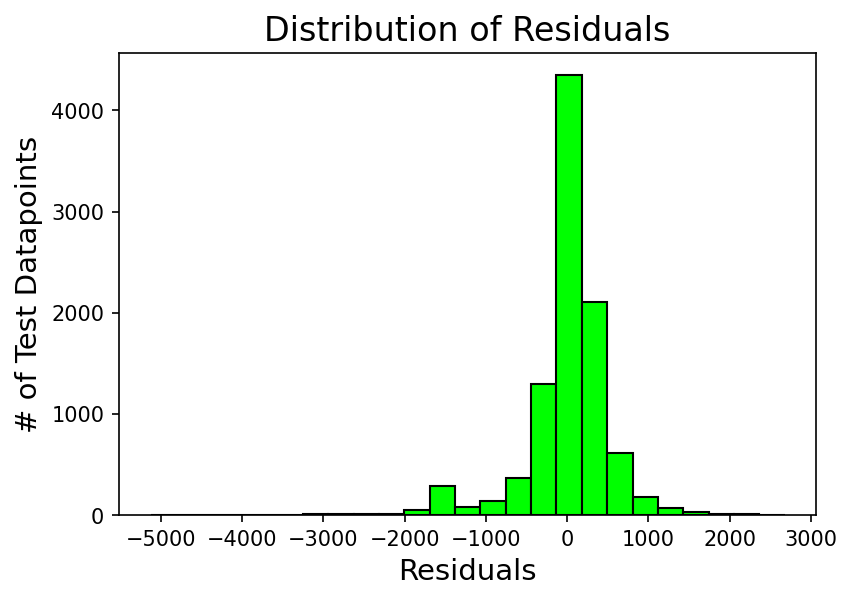

In [8]:

all_residuals = test_y - y_pred
plt.figure(figsize=(6, 4), dpi = 150)
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)
plt.title('Distribution of Residuals', fontsize = 16)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig("residuals.svg");

#### Scatter Plot of Predicted Vs. Actual Values

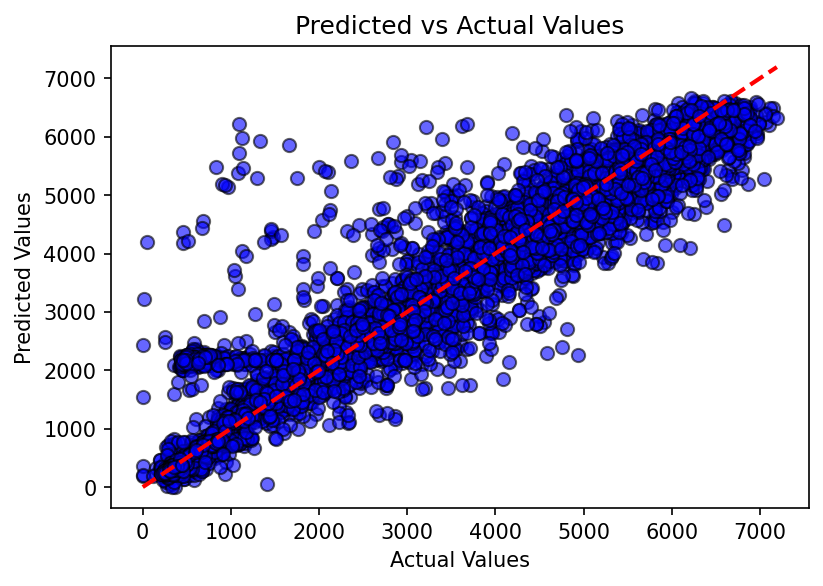

In [9]:
plt.figure(figsize = (6, 4), dpi = 150)
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig("scatter_plot.svg");

#### Feature Importance Plot

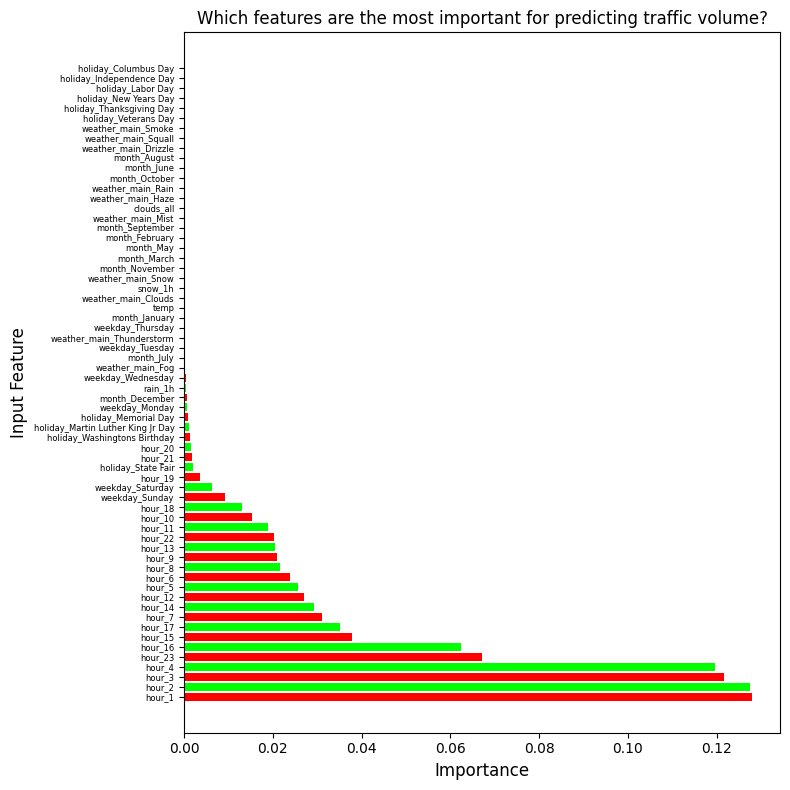

In [10]:
importance = xg_reg.feature_importances_
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)
plt.figure(figsize=(8, 8))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])
plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting traffic volume?', fontsize = 12) 
plt.yticks(fontsize = 6) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks
plt.tight_layout()
plt.savefig("feature_imp.svg");

In [11]:
# Training Mapie model
model = XGBRegressor()
mapie = MapieRegressor(estimator = model, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 5.793878078460693s


In [12]:
# Predicted values
y_test_pred

array([5849.472 , 2199.1655, 2260.0046, ..., 1939.2333, 2517.5415,
        575.0571], dtype=float32)

In [13]:
# Prediction Intervals
y_test_pis

array([[[4989.23754883],
        [6590.77246094]],

       [[1443.80322266],
        [3026.95874023]],

       [[1486.55322266],
        [3071.4440918 ]],

       ...,

       [[1153.34460449],
        [2737.80163574]],

       [[1775.08569336],
        [3369.1965332 ]],

       [[-236.7333374 ],
        [1346.41717529]]])

In [14]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
6401,2491,2796.050049,2035.30,3628.24
34004,5251,5189.890137,4431.50,6017.89
46086,2224,1939.229980,1153.34,2737.80
42579,2928,2517.540039,1775.09,3369.20
23709,910,575.059998,-236.73,1346.42


In [15]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.07%


c:\Users\Tillman\anaconda3\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


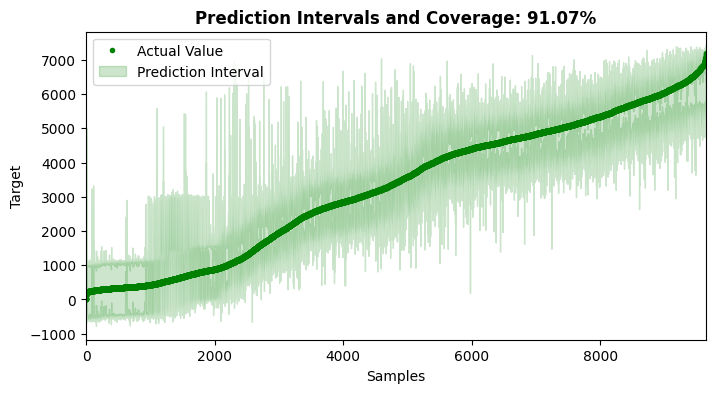

In [16]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10)
plt.savefig("coverage.svg");

In [17]:
#Saving model
mapie_pickle = open('mapie_pickle.pkl', 'wb')
pickle.dump(mapie, mapie_pickle)
mapie_pickle.close()